# Goal

write a function that looks for *all* YY/RR di-nucleotides in the WT-fragment stuffer DNA and then changes exactly those dinucleotides to YY/RR in another DNA.

# Init

In [3]:
from Bio import SeqIO
from Bio.Seq import Seq, MutableSeq
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def find_string_overlapping(query, target):
    return([i for i in range(len(target)) if target[i:i+len(query)] == query])

In [5]:
def find_dinucleotide(sequence, dinucleotide):

    nucleotide_code = {
        "Y": ["T", "C"],
        "R": ["A", "G"],
        "S": ["G", "C"],
        "W": ["A", "T"],
        "M": ["A", "C"],
        "K": ["G", "T"],
        "A": ["A"],
        "G": ["G"],
        "C": ["C"],
        "T": ["T"],
        "N": ["A", "G", "C", "T"]
    }

    if not all([x in nucleotide_code for x in dinucleotide]):
        raise Exception("Some nucleotides are weird and are not in my list bro")
        
        
    # Use itertools product to get all the combinations
    l1 = nucleotide_code[dinucleotide[0]]
    l2 = nucleotide_code[dinucleotide[1]]
    combinations = [''.join(x) for x in itertools.product(l1, l2)]
    
    # find all combinations in the sequence
    l = []
    for query in combinations:
        l.append(find_string_overlapping(query, sequence))
    
    # put them all in the same list and sort
    coordinates = [y for x in l for y in x]
    coordinates.sort()
    return(coordinates)

In [6]:
def pw_distance(v1, v2, max_distance = 100):
    return([abs(i-j) for i in v1 for j in v2 if abs(i-j)<=max_distance])

In [7]:
def create_mask(sequence, dinucleotide):
    coordinates = find_dinucleotide(sequence, dinucleotide)
    return({c:sequence[c:c+2] for c in coordinates})

In [8]:
def apply_mask(sequence, mask):

    if not type(sequence) == Seq:
        raise Exception("sequence must be a Biopython Seq object")
        
    out_seq = MutableSeq(sequence)

    for coord in mask:
        out_seq[coord:coord+2] = mask[coord]

    return(Seq(out_seq))

In [9]:
def plot_YY_RR(sequence):

    coord1 = find_dinucleotide(sequence, "YY")
    coord2 = find_dinucleotide(sequence, "RR")

    dist_df = pd.concat(
        [pd.DataFrame({
            "anchor": "YY",
            "dist_to": "YY",
            "distance": pw_distance(coord1, coord1)}),
        pd.DataFrame({
            "anchor": "YY",
            "dist_to": "RR",
            "distance": pw_distance(coord1, coord2)})]).reset_index(drop=True)

    sns.histplot(
        data=dist_df,
        x="distance",
        hue="dist_to",
        stat="count",
        binwidth=1,
        kde=True,
        kde_kws = {"bw_adjust": 0.4},
        element="step"
    )
    plt.xlim(0, 50)

In [10]:
aav_seqs = {entry.description: entry.seq.upper() for entry in SeqIO.parse("../sequences/aav/AAV_serotypes.periodConstructs.fasta", "fasta")}

In [11]:
wtf_seq_complete = aav_seqs["WTF_4.8"]
wt_fragments = wtf_seq_complete[1942:4561]

In [12]:
print("The stuffer DNA has the length of {} bp".format(len(wt_fragments)))

The stuffer DNA has the length of 2619 bp


# All RR and YY di-nucleotides
## Sanity check - Distance Histogram

(0.0, 50.0)

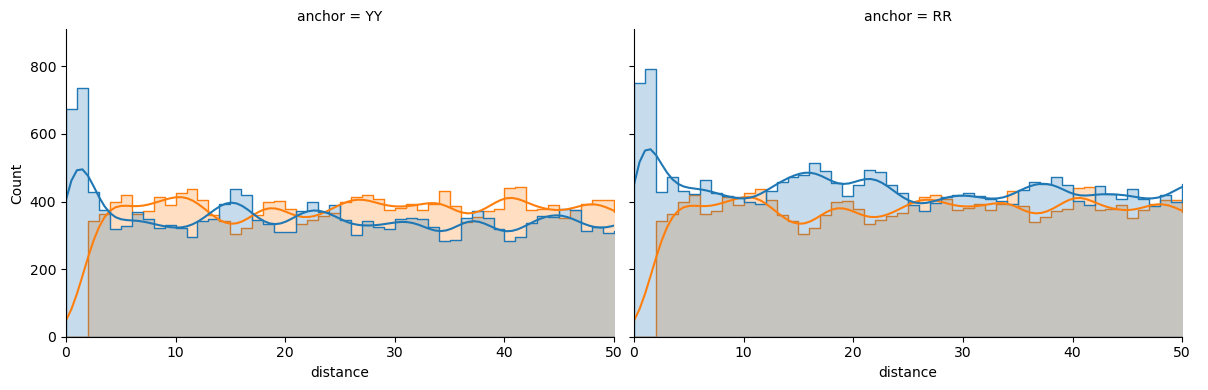

In [13]:
coord1 = find_dinucleotide(wt_fragments, "YY")
coord2 = find_dinucleotide(wt_fragments, "RR")

dist_df = pd.concat(
    [pd.DataFrame({
        "anchor": "YY",
        "dist_to": "YY",
        "distance": pw_distance(coord1, coord1)}),
    pd.DataFrame({
        "anchor": "YY",
        "dist_to": "RR",
        "distance": pw_distance(coord1, coord2)}),
    pd.DataFrame({
        "anchor": "RR",
        "dist_to": "RR",
        "distance": pw_distance(coord2, coord2)}),
    pd.DataFrame({
        "anchor": "RR",
        "dist_to": "YY",
        "distance": pw_distance(coord2, coord1)})
    ]
).reset_index(drop=True)

g = sns.FacetGrid(dist_df, col="anchor", height=4, aspect=1.5)
g.map_dataframe(
    sns.histplot,
    x="distance",
    hue="dist_to",
    stat="count",
    binwidth=1,
    kde=True,
    kde_kws = {"bw_adjust": 0.4},
    element="step")
g.add_legend()
plt.xlim(0,50)

(0.0, 50.0)

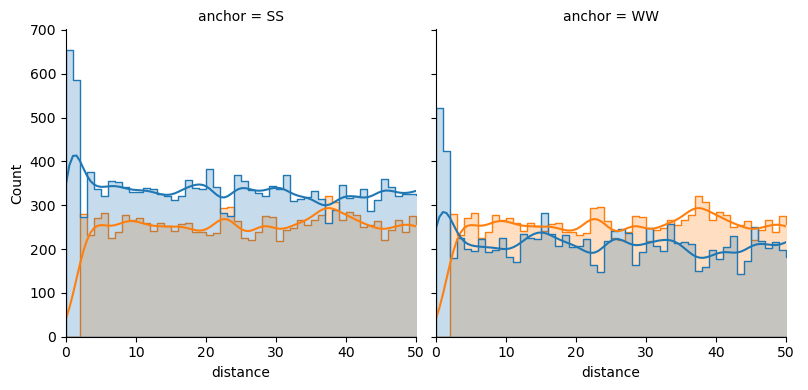

In [14]:
coord1 = find_dinucleotide(wt_fragments, "SS")
coord2 = find_dinucleotide(wt_fragments, "WW")

dist_df = pd.concat(
    [pd.DataFrame({
        "anchor": "SS",
        "dist_to": "SS",
        "distance": pw_distance(coord1, coord1)}),
    pd.DataFrame({
        "anchor": "SS",
        "dist_to": "WW",
        "distance": pw_distance(coord1, coord2)}),
    pd.DataFrame({
        "anchor": "WW",
        "dist_to": "WW",
        "distance": pw_distance(coord2, coord2)}),
    pd.DataFrame({
        "anchor": "WW",
        "dist_to": "SS",
        "distance": pw_distance(coord2, coord1)})
    ]
).reset_index(drop=True)

g = sns.FacetGrid(dist_df, col="anchor", height=4)
g.map_dataframe(
    sns.histplot,
    x="distance",
    hue="dist_to",
    stat="count",
    binwidth=1,
    kde=True,
    kde_kws = {"bw_adjust": 0.4},
    element="step",
    legend=True
)
g.add_legend()
plt.xlim(0,50)

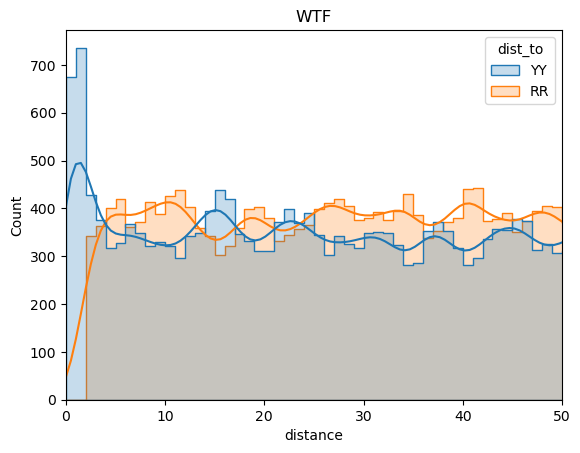

In [15]:
plot_YY_RR(wt_fragments)
plt.title("WTF")
plt.savefig("../periodify/mask/raw_sequences/wtf_YY.histogram.png", dpi=100)

# Create mask

In [16]:
YY_mask = create_mask(wt_fragments, "YY")
RR_mask = create_mask(wt_fragments, "RR")

# Apply mask

## test sequence

In [17]:
test_seq = Seq("."*len(wt_fragments))
test_seq

Seq('............................................................')

In [18]:
print(apply_mask(test_seq, YY_mask))

TC......CTC.............TT.CCTC..............TCC.......CC...CCTC.....TCTCCTTC.......CCTCC..CTC....TCCC...TC....CT.CCTT.................TT.....CCT..CT....CC.CCCCC..CT.CCT......CC.....CCC..........TTTCC.....TC...TTT......TTTT....CT............TCCCC.........CTTCC.TCTTTCT........CC.........TTC.............CC.TCT..CT.TTT...CCT....CT.CC.......CC....TC.......CC....CCC...CT...CCCTTCT.............CT...CC........CTTTCCCTTC.....CT...TC.............TCT.....................CC.CC....TC......TC..CC....CC.TTCTC.......................CC...........TCCTC..CCC.......CCC..CTCCC....TC.TC.CCTCC....CC..........CC....TT........CTC.....CCTTC.....CC.....CC.TT......CC.....TT....................CC.......................CC..............TTCCTC......TT....TT....TTCC...................TC.TC.CC.CC....CCC...CCT...CCCT.CCC.CCT.......CC.CCTCT.........TTTCC..CC..TC.....CCTC.........TC.CT.CTTT..CT......CCCCTT.......TTTT..CTTC......TTCC.CT.CC.CTTTTC.CC......CT........CTC.TC........CT.....TTCC..CCC......CTC..CTTC...CTCTTT....

In [19]:
print(apply_mask(test_seq, RR_mask))

..GGG.GG.....GGA.AAGGGGA.......GGAGAAG.AG.GGA...AGGAGGA..AGG.................AA...GG.....AA.....GG....AAA..AAGG.......GGA.AA...GGGAAAGA....GAG...GA..AAAA........GA......GG.GGG..AG.AG.....GGAGGA.......AG.AA..GGA.....AAAA....GGAA..AAA.GGG...GA.....AA.....GG.............GGGA.GGG....GAAAAAG...GG.AAGAGGAA........GG......GGG.....AA.....GGGAAGA..AA......GGAGG....AG....................GGG.....AAA..GGA..AA.GAGAA..........AA.GA.......GA.AAGA.GG.GA...GG.GGGAGGAGGGGAAGA.GA.....AAGG....GGAG..GG..AAAG........GGAGGAAG.AAGG.......GGA..AGAAA...AAG.....GG...AGA.AGA...GA.......GA...........AA....AA............GA..GA.GGGAA...AA.GA.....GAA....AG.AG.......AAGA..GGA....AA.....AGG.AG.GG......AA.GG.AGA.AA.AA.GAGGG....GA.GGAG.GGG.AA......GGGAAA..GG......GA........GGA.GGG.GA.AGAG...........AG.....GAA...GGG..............AA.AA..........AAA.AAA.....AG..AA..AGGAG....GAA.GA.AA..........GG....AG........GGGGG......GA....AA.AGA........................GA..GG.AAAGA......AA.AA.AA..GGGGA....GA...AAGAGA...AA....AAG......AA..

In [20]:
t1 = apply_mask(test_seq, YY_mask)
both_masks = apply_mask(t1, RR_mask)

In [21]:
print(both_masks)

TCGGG.GGCTC..GGA.AAGGGGATT.CCTCGGAGAAG.AG.GGATCCAGGAGGACCAGGCCTC.....TCTCCTTCAA...GGCCTCCAACTC..GGTCCCAAATCAAGGCT.CCTTGGA.AA...GGGAAAGATT..GAGCCTGACTAAAACC.CCCCCGACT.CCTGG.GGGCCAG.AGCCC..GGAGGA..TTTCCAG.AATCGGATTT..AAAATTTTGGAACTAAA.GGG...GATCCCCAA.....GGCTTCC.TCTTTCTGGGA.GGGCC..GAAAAAGTTCGG.AAGAGGAA..CC.TCTGGCT.TTTGGGCCT..AACT.CCGGGAAGACCAA..TC..GGAGGCC..AGCCC...CT...CCCTTCT..GGG.....AAACTGGACCAA.GAGAACTTTCCCTTCAA.GACT...TCGA.AAGA.GG.GATCTGG.GGGAGGAGGGGAAGA.GACC.CCAAGGTC..GGAGTCGGCCAAAGCC.TTCTCGGAGGAAG.AAGG.......GGACCAGAAA...AAGTCCTCGGCCCAGA.AGACCCGACTCCC..GATC.TC.CCTCCAA..CCAA........CC..GATTGA.GGGAACTCAA.GACCTTCGAA..CCAG.AGCC.TT..AAGACCGGA..TTAA.....AGG.AG.GG....CCAA.GG.AGA.AA.AA.GAGGG..CCGA.GGAG.GGG.AATTCCTCGGGAAATTGG..TT..GATTCC....GGA.GGG.GA.AGAGTC.TC.CC.CCAG..CCCGAACCTGGGCCCT.CCC.CCT..AA.AACC.CCTCT..AAA.AAATTTCCAGCCAATCAGGAGCCTCGAA.GA.AATC.CT.CTTTGGCT..AG..CCCCTTGGGGG..TTTTGACTTCAA.AGATTCC.CT.CC.CTTTTC.CC....GACTGG.AAAGACTC.TCAA.AA.AACTGGGGATTCCGACCCAAGAGACTCAACTTCAAGCTCTTTAA..

In [23]:
both_masks.count(".") / len(both_masks)

0.20351279114165713

Both masks together would permute 80% of any sequence put in. So be it. Then I can consider it as a positive control.

## lambda stuffer

In [92]:
lambda_seq_complete = aav_seqs["lambda_4.8"]
ld_fragments = lambda_seq_complete[1941:4568]

## sanity

(0.0, 50.0)

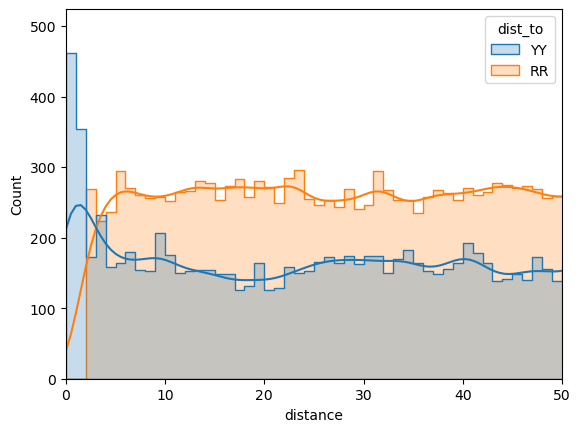

In [93]:
# lambda
coord1 = find_dinucleotide(ld_fragments, "YY")
coord2 = find_dinucleotide(ld_fragments, "RR")

dist_df = pd.concat(
    [pd.DataFrame({
        "anchor": "YY",
        "dist_to": "YY",
        "distance": pw_distance(coord1, coord1)}),
    pd.DataFrame({
        "anchor": "YY",
        "dist_to": "RR",
        "distance": pw_distance(coord1, coord2)})]).reset_index(drop=True)

sns.histplot(
    data=dist_df,
    x="distance",
    hue="dist_to",
    stat="count",
    binwidth=1,
    kde=True,
    kde_kws = {"bw_adjust": 0.4},
    element="step"
)
plt.xlim(0, 50)

In [94]:
print(wt_fragments)

TCGGGTGGCTCGTGGACAAGGGGATTACCTCGGAGAAGCAGTGGATCCAGGAGGACCAGGCCTCATACATCTCCTTCAATGCGGCCTCCAACTCGCGGTCCCAAATCAAGGCTGCCTTGGACAATGCGGGAAAGATTATGAGCCTGACTAAAACCGCCCCCGACTACCTGGTGGGCCAGCAGCCCGTGGAGGACATTTCCAGCAATCGGATTTATAAAATTTTGGAACTAAACGGGTACGATCCCCAATATGCGGCTTCCGTCTTTCTGGGATGGGCCACGAAAAAGTTCGGCAAGAGGAACACCATCTGGCTGTTTGGGCCTGCAACTACCGGGAAGACCAACATCGCGGAGGCCATAGCCCACACTGTGCCCTTCTACGGGTGCGTAAACTGGACCAATGAGAACTTTCCCTTCAACGACTGTGTCGACAAGATGGTGATCTGGTGGGAGGAGGGGAAGATGACCGCCAAGGTCGTGGAGTCGGCCAAAGCCATTCTCGGAGGAAGCAAGGTGCGCGTGGACCAGAAATGCAAGTCCTCGGCCCAGATAGACCCGACTCCCGTGATCGTCACCTCCAACACCAACATGTGCGCCGTGATTGACGGGAACTCAACGACCTTCGAACACCAGCAGCCGTTGCAAGACCGGATGTTAACGTACAGGCAGTGGCGCACCAATGGCAGACAATAACGAGGGCGCCGACGGAGTGGGTAATTCCTCGGGAAATTGGCATTGCGATTCCACATGGATGGGCGACAGAGTCATCACCACCAGCACCCGAACCTGGGCCCTGCCCACCTACAACAACCACCTCTACAAACAAATTTCCAGCCAATCAGGAGCCTCGAACGACAATCACTACTTTGGCTACAGCACCCCTTGGGGGTATTTTGACTTCAACAGATTCCACTGCCACTTTTCACCACGTGACTGGCAAAGACTCATCAACAACAACTGGGGATTCCGACCCAAGAGACTCAACTTCAAGCTCTTTAACA

In [95]:
print(ld_fragments)

GAGTATCCGTGAGAACGACGACGGCACGTATGCCATCACCGCCGTGCAGCATGTGCCGGAAAAAGAGGCCATCGTGGATAACGGGGCGCACTTTGACGGCGAACAGAGTGGCACGGTGAATGGTGTCACGCCGCCAGCGGTGCAGCACCTGACCGCAGAAGTCACTGCAGACAGCGGGGAATATCAGGTGCTGGCGCGATGGGACACACCGAAGGTGGTGAAGGGCGTGAGTTTCCTGCTCCGTCTGACCGTAACAGCGGACGACGGCAGTGAGCGGCTGGTCAGCACGGCCCGGACGACGGAAACCACATACCGCTTCACGCAACTGGCGCTGGGGAACTACAGGCTGACAGTCCGGGCGGTAAATGCGTGGGGGCAGCAGGGCGATCCGGCGTCGGTATCGTTCCGGATTGCCGCACCGGCAGCACCGTCGAGGATTGAGCTGACGCCGGGCTATTTTCAGATAACCGCCACGCCGCATCTTGCCGTTTATGACCCGACGGTACAGTTTGAGTTCTGGTTCTCGGAAAAGCAGATTGCGGATATCAGACAGGTTGAAACCAGCACGCGTTATCTTGGTACGGCGCTGTACTGGATAGCCGCCAGTATCAATATCAAACCGGGCCATGATTATTACTTTTATATCCGCAGTGTGAACACCGTTGGCAAATCGGCATTCGTGGAGGCCGTCGGTCGGGCGAGCGATGATGCGGAAGGTTACCTGGATTTTTTCAAAGGCAAGATAACCGAATCCCATCTCGGCAAGGAGCTGCTGGAAAAAGTCGAGCTGACGGAGGATAACGCCAGCAGACTGGAGGAGTTTTCGAAAGAGTGGAAGGATGCCAGTGATAAGTGGAATGCCATGTGGGCTGTCAAAATTGAGCAGACCAAAGACGGCAAACATTATGTCGCGGGTATTGGCCTCAGCATGGAGGACACGGAGGAAGGCAAACTGAGCCAGTTTCTGGTTGCCGCCAATCGTATCGCATTTATTGACCCG

In [96]:
ld_wtfied = apply_mask(apply_mask(ld_fragments, YY_mask), RR_mask)

In [97]:
print(ld_wtfied)

TCGGGTGGCTCAGGGAGAAGGGGATTCCCTCGGAGAAGCAGCGGATCCAGGAGGACCAGGCCTCGAGGCTCTCCTTCAAAACGGCCTCCAACTCGAGGTCCCAAATCAAGGCTCCCTTGGAGAAGTCGGGAAAGATTCGGAGCCTGACTAAAACCCCCCCCGACTTCCTGGCGGGCCAGAAGCCCAGGGAGGAGCTTTCCAGGAATCGGATTTGGAAAATTTTGGAACTAAATGGGTGCGATCCCCAACCGTAGGCTTCCATCTTTCTGGGAAGGGCCTGGAAAAAGTTCGGCAAGAGGAAGACCCTCTGGCTCTTTGGGCCTAAAACTCCCGGGAAGACCAAAGTCTGGGAGGCCGGAGCCCAAACTCGTCCCTTCTGCGGGGCGATAAACTGGACCAATGAGAACTTTCCCTTCAACGACTAGCTCGATAAGAGGGTGATCTGGCGGGAGGAGGGGAAGAGGACCCCCAAGGTCCGGGAGTCGGCCAAAGCCATTCTCGGAGGAAGTAAGGGTTCTGGGGACCAGAAAAGCAAGTCCTCGGCCCAGAAAGACCCGACTCCCGCGATCGTCACCTCCAAACCCAACTGTACTGCCTAGATTGAAGGGAACTCAACGACCTTCGAAATCCAGAAGCCTTTTAAAGACCGGATGTTAACACCGAGGGAGAGGCGGCCCAAGGGGAGACAATAAGGAGGGCGCCGAAGGAGGGGGAAATTCCTCGGGAAATTGGCATTGGGATTCCAACCGGATGGGAGATAGAGTCGTCGCCGCCAGAACCCGAACCTGGGCCCTACCCTCCTGCAAGAACCCCCTCTGAAAATAAATTTCCAGCCAATCAGGAGCCTCGAAAGAGAATCGCTACTTTGGCTGTAGAACCCCTTGGGGGCATTTTGACTTCAAAAGATTCCGCTGCCACTTTTCTCCGCATGACTGGCAAAGACTCATCAAAAATAACTGGGGATTCCGACCCAAGAGACTCAACTTCAAGCTCTTTAACG

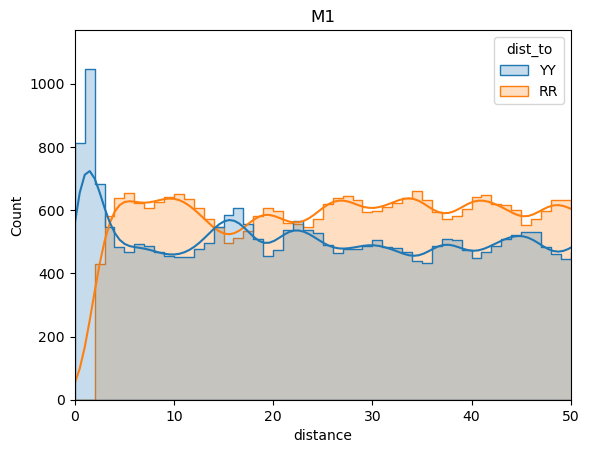

In [98]:
plot_YY_RR(ld_wtfied)
plt.title("M1")
plt.savefig("../periodify/mask/raw_sequences/M1_YY.histogram.png", dpi=100)

Looking at the MSA, this method makes the lambda stuffer much closer to the WT DNA than I would have liked. But that was to be expected when I change 80% of the sequence.

In [99]:
with open("../periodify/mask/raw_sequences/m1_lambda.fasta", "w") as out:
    out.write(">m1_lambda\n")
    out.write(str(ld_wtfied) + "\n")

# Only di-nucleotides exactly 15 bp apart

In [100]:
def find_distance_exact(v1, v2, distance, margin=0):
    # margin is bugged right now!! leave at 0
    return([(i, j) for i in v1 for j in v2 if j-i in np.linspace(distance-margin, distance+margin, 2*margin+1)])

In [101]:
def create_mask_exact(sequence, dinucleotide1, dinucleotide2, distance = 15):
    
    coord1 = find_dinucleotide(sequence, dinucleotide1)
    coord2 = find_dinucleotide(sequence, dinucleotide2)

    good_distance = find_distance_exact(coord1, coord2, distance = distance, margin=0)

    good_ones1, good_ones2 = [x[0] for x in good_distance], [x[1] for x in good_distance]

    return {x: wt_fragments[x:x+2] for x in good_ones1}, {x: wt_fragments[x:x+2] for x in good_ones2}

## create mask

In [102]:
YY_mask1, YY_mask2 = create_mask_exact(wt_fragments, "YY", "YY")
YY_exact_mask = {**YY_mask1, **YY_mask2}

RR_mask1, RR_mask2 = create_mask_exact(wt_fragments, "RR", "RR")
RR_exact_mask = {**RR_mask1, **RR_mask2}

## test sequence

In [103]:
t1 = apply_mask(test_seq, YY_exact_mask)
print(t1)

.........TC.............TT...................TCC.......CC...CCT......TCTCC.TC.......CCTCC..........CCC............CCT.........................CCT............CCC.......CT.............CCC..........TTTCC.....TC...TTT.......TT.....CT............TCCC...........TTCC.TC.............CC..........TC.............CC.TC.......TT....CT.......CC.......CC....TC.......CC....CCC............TCT.............CT...CC........CT...CC........CT...TC.............TC.......................................TC.............CT........................CC.............CTC..CCC.......CCC..CTCCC....TC....CCTCC....CC....................................TT.............CC.TT.............TT................................................................CT.............TT...........................TC....CC.......CC....CCT............CCT..........CCTCT..........TTCC.............CCT.............CT.CTTT..........CCCCTT........TTT..CT........TTC..CT....CT..TC.........CT.............................TTC...CCC......CTC...TTC....TCTTT....

In [104]:
apply_mask(test_seq, RR_exact_mask)

Seq('..GGG.GG.........AAGGGG.........GAGAAG....GGA...AGGAG.......')

In [105]:
masked_test = apply_mask(t1, RR_exact_mask)
print(masked_test)

..GGG.GG.TC......AAGGGG.TT......GAGAAG....GGATCCAGGAG..CCAGGCCT......TCTCC.TC.......CCTCC..........CCC.AA..AA.....CCT.GG..AA......AA.GA.......CCTGA..........CCC.......CT...GGG.......CCC..GGA.....TTTCCAG.AATC.GATTT..AA...TT.GGA.CT.AA.......GATCCC........GG.TTCC.TC.....GGGA....CC..GAAAAAG.TC....AGAGGAA..CC.TC.GG....TTGGG.CT.......CCGGGAAGACC....TC..GGAGGCC....CCC............TCT..........AAACT...CC...GAGAACT...CC...AA.GACT...TC...AAGA.GG.GATC.GG.GGG.GG.GGGGAAG..GA.....AAGG....GG..TC....AAAG.....CT....GGAAG..AGG.......GGACCAGA..........CTCGGCCC....AG.CCCGACTCCC..GATC....CCTCC....CC..............GA........AA...AA.....TT.GA........AGCC.TT........GG...TT.......AGG....GG......AA.GG..GA.AA.AA...GGG....GA.GGAG.GGG......CT.GGGAAA......TT..GA.............GG....AG..TC....CC...AG..CC....CCT............CCT..AA......CCTCT..AAA..AA.TTCC....AA..AGG..CCT.....GA.AA...CT.CTTTGG........CCCCTT..GG....TTT..CT..AA....TTC..CT....CT..TC.........CT.....AG.............AA..GGGGATTC...CCCAAGAGACTCAA.TTCAAG.TCTTTAA..

In [106]:
masked_test.count(".") / len(masked_test)

0.5269186712485682

Now "only" 50% of the sequence is altered

## Lambda sequence

In [107]:
masked_lambda_exact = apply_mask(apply_mask(ld_fragments, YY_exact_mask), RR_exact_mask)

In [108]:
ld_fragments

Seq('GAGTATCCGTGAGAACGACGACGGCACGTATGCCATCACCGCCGTGCAGCATGT...TCC')

In [109]:
print(masked_lambda_exact)

GAGGGTGGGTCAGAACGAAGGGGGTTCGTATGGAGAAGCCGCGGATCCAGGAGTGCCAGGCCTAGAGGCTCTCCTTCATAACGGCCTCCACTTTGACGGCCCAAAGAAAGGCACCCTGGGTGAAGTCACGAAGGAAGCGGTGCCTGACCTGACCGCACCCGTCACTGCTGACGGGGGGGAATCCCAGGGACTGGCTTTCCAGGAATCAGATTTGGAAGTGTTGGGAGCTAAATTCCTGCGATCCCTGACCGTAGGATTCCATCACGGCGGGAAGCGCCTGGAAAAAGCTCCCCGAGAGGAAGACCCTCCGGACCGTTGGGCCTAACTGGCCCGGGAAGACCACAGTCTGGGAGGCCGGGCCCCAAATGCGTGGGGTCTGCAGGGCGATAAACTGTCCCTATGAGAACTGATCCCCGAACGACTAGCTCCGTAAGAGGGTGATCTGGCGGGGGGCGGGGAAGAGGAAACCGAAGGGCCGGGTCTCGCCGAAAGTGACCCTACGGGGAAGTTAGGGTTCTGGGGACCAGAAAAGCAGATTCTCGGCCCCAGAAGGCCCGACTCCCGCGATCGTTACCTCCGTACCCCGCTGTACTGGATAGACGCCAGTAAAAATAACAAACTTGGACATGATTAAGCCTTTTATATCCGGGGTGTTAACACCGAGGGCAAGGCGGCATAAGGGGAGACAATAAGTCGGGCGAGGAAGGAGGGGGAAGGTTCTCGGGAAATTTTCATTGGGAAGATAACCGAATCGGATCTAGGCTCGGAGCCGCTAGAACCAGTCCCTCTGACGGAGGATCCTGCAAGCAGACCCTCTGAAAATTAAATTCCGTGGAAGGAGGCCCCTGATAAGAGAAATGCTACTTTGGCTGTCAAACCCCTTCAGGCCAATTTCGCTAAAAATTATTCCGCTGGTACTGGTCTCAGCATGGCTGACACAGAGGAAGGCAAACTAAGCGGGGATTCGGTCCCAAGAGACTCAATTTCAAGTTCTTTAACG

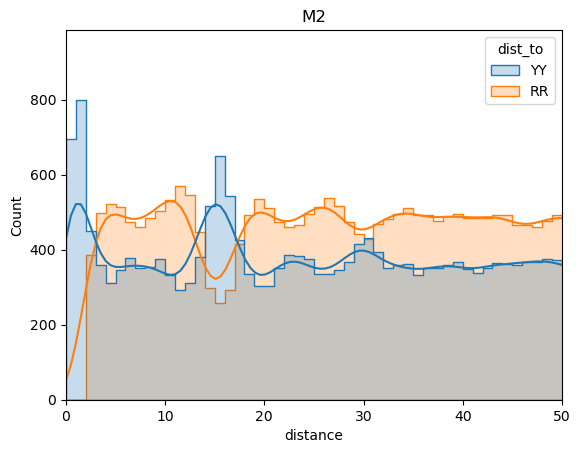

In [110]:
plot_YY_RR(masked_lambda_exact)
plt.title("M2")
plt.savefig("../periodify/mask/raw_sequences/M2_YY.histogram.png", dpi=100)

Looking at the MSA between the modifed lambda sequence, the unmodified lambda, and the wt-fragments now gives a much more cleaner look of a 50-50 mix between the 2 sequences. I like this much better than before.

In [111]:
with open("../periodify/mask/raw_sequences/m2_lambda.fasta", "w") as out:
    out.write(">m2_lambda\n")
    out.write(str(masked_lambda_exact) + "\n")